# SWMM with Python Week 1: Setup the Environment

Python is probably the best language for data analysis, it has a huge ecosystem of libraries. If you are interested in applying the latest data science anlysis to your swmm model, let's get started.

In this notebook, I am going to show the following,

- install python and requried libraries
- run a swmm model and get results at each time step
- run a swmm model, then extract results from the \*.out file



# Required Software

## Python

I would recommend using [anaconda](https://www.anaconda.com/products/individual) to simpify the installation of python. I am using the 64bit python 3.7 on a Windows 10 laptop for this notebook.


## Jupyter Lab

Then setup [Jupyter Lab](https://dzone.com/articles/getting-started-with-jupyterlab), open the Anaconda prompt in Windows start menu.

Then run the following commands

```powershell
conda install -c conda-forge jupyterlab
jupyter lab
```


## PySwmm

Install [pyswmm](https://github.com/OpenWaterAnalytics/pyswmm) using the anaconda prompt
```
pip install pyswmm
```


## swmm-python

[swmm-python](https://github.com/OpenWaterAnalytics/swmm-python) is still in pre-release, the installation is a little more tricky.

This is the [release](https://github.com/OpenWaterAnalytics/swmm-python/releases/tag/v0.3.0-dev1) I used. Download the .whl file matching my version of python.

I installed [swmm.output for 64bit python 3.7](https://github.com/OpenWaterAnalytics/swmm-python/releases/download/v0.3.0-dev1/swmm.output-0.4.0.dev1-cp37-cp37m-win_amd64.whl)

1. download the \*.whl file to your computer
1. start anaconda prompt and run the command below
```bash
pip install "c:...path to the whl file"
```

I can no longer find the swmm5 interface files from EPA website. Here is the link to the documentation I found on [github](https://github.com/ufz/SwmmInterface/blob/master/Interfacing.chm). It has detailed information on the output file format in Appendix B.


# Get the data

I am going to use the pyswmm [example input file](https://raw.githubusercontent.com/OpenWaterAnalytics/pyswmm/master/pyswmm/tests/data/model_full_features.inp). Download it and save it to my hard drive.



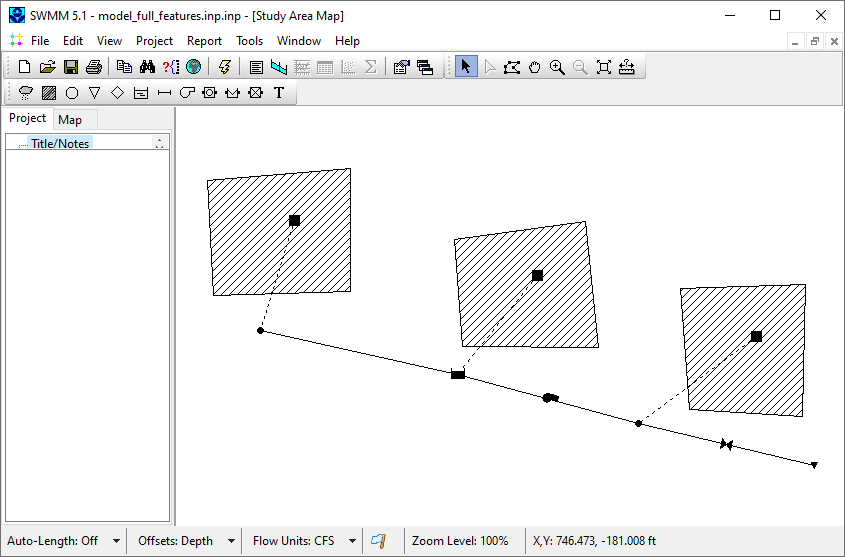

# Run a swmm model using pySWMM

pySWMM is very powerful if you are interested in real-time applications. You can run the model one time step a time and then make changes to the controls.

In the code sample below, I simply collect the subcachement results into a time series and then plot it.

If you are not familiar with python yet, you might find it a little hard to read python code. If you spend 30 min taking one of the many free online python training resources, you'll be able to read it. They are pretty much engilish. I included some comments (the line after #) to make it easier to read.

In [6]:
# this section imports the libraries needed. tools other poeple developed to solve out problem.
from pyswmm import Simulation, Subcatchments
import pandas as pd
import matplotlib.pyplot as plt

# the line below opens the *.inp file and save the simulation object as variable sim, using this syntax will close the object automatically. It is fine if you don't understand it.
with Simulation(r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\swmm_and_python\data\model_full_features.inp") as sim:
    # S1, S2 get the subcatchments by their names
    S1 = Subcatchments(sim)["S1"]
    S2 = Subcatchments(sim)["S2"]
    
    # we need to create a time series table, idx is the time, s1_values, s2_values are the two columns for the runoff of s1 and s1
    idx = []
    s1_values = []
    s2_values = []
    
    # as we are looping through each time step, we add the simulated value into the 3 coloumns variables above
    for step in sim:
        idx.append(sim.current_time)
        s1_values.append(S1.runoff)
        s2_values.append(S2.runoff)
    
    # using this line below, we turn the 3 columns into a table, called DataFrame using the pandas library. So that we can plot it.
    df = pd.DataFrame({'S1 Runoff': s1_values, 'S2 Runoff': s2_values}, index=idx)
    

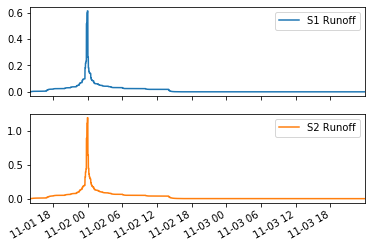

          S1 Runoff      S2 Runoff
count  2.088000e+05  208800.000000
mean   1.676060e-02       0.033509
std    4.602423e-02       0.089107
min    5.242432e-07       0.000003
25%    2.041189e-06       0.000011
50%    5.029121e-05       0.000253
75%    2.420089e-02       0.048402
max    6.128817e-01       1.188562


In [7]:
# let's compare s1 and s2 results
# with the pandas plot, it is so easy to plot tabular data.
df.plot(subplots=True)

# this line shows the figure below
plt.show()

# this line prints the summary of the table
print(df.describe())

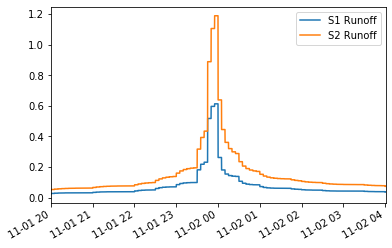

In [8]:
# let's zoom in and compare the peak
# you might find the syntax a little strange, but once you get used to it, it is very powerful, we limit the data within the time range below.
df['11/1/2015 20:00':'11/02/2015 4:00'].plot(subplots=False)
plt.show()

# Use swmm.output to read the results from \*.out file

If we are only interested in reading the results, we can get the result directly from the output file.

The swmm.output lib is built for that purpose.

In [9]:
from pyswmm import Simulation, Subcatchments
import pandas as pd
import matplotlib.pyplot as plt

# run the model to get the *.out file without going through each time step
sim = Simulation(r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\swmm_and_python\data\model_full_features.inp")
sim.execute()


... SWMM Version 5.3.0.dev0
... Run Complete

The swmm.output library is a low level library that provides direct access the \*.out file. So we need to a little bit about the data structure to get the results.

The swmm_dt function below converts the date integer SWMM out file uses to a date.

In [1]:
from swmm.output import output as smo
import datetime
def swmm_dt(days):
    # swmm saves dates as a number, here we convert swmm dates number to date
    # https://www.openswmm.org/Topic/4343/output-file-start-date-and-time-of-the-simulation
    t0 = pd.to_datetime('12/31/1899 00:00')
    t1 = t0 + datetime.timedelta(days=(days-1)) # I don't understand why I need to -1, hey it works. 
    return t1

The code block below extracts the s1, s2 subcatchments time series from the \*.out file. Since we get the data from the output file, it is reported values, not the same values we got from each time step during the simulation. So we'll compare the two ways of retrieving the data, and see if they look the same.

In [11]:
# extract the results from *.out file

# this is how swwwm.output opens a output file.
handle = smo.init()
smo.open(handle, r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\swmm_and_python\data\model_full_features.out")

# in similar manner, we need to build 3 columns, time, s1 and s1
# for timestep it is a little more complicated
# swmm output file only report, report start date, report time step and the number of steps simulated.
# so we need to convert that to a list of time stamps

report_start_date_time = smo.getstartdate(handle)
# convert the number to a date
start_dt = swmm_dt(report_start_date_time)

# to build the timestamps, we'll need the number of reported steps, and the step length in seconds
num_steps = smo.gettimes(handle, smo.Time.NUM_PERIODS)
report_step = smo.gettimes(handle, smo.Time.REPORT_STEP)

# build the date range, pd.date_range can build a list of timestamps.
timestep = pd.date_range(start=start_dt, periods=num_steps, freq='%smin' % (report_step/60.0))


# you need to access subcatchment using index, since we have only 3 subcatchments, 0 is s1, 1 is s2
print(smo.getelementname(handle, smo.ElementType.SUBCATCH, 0))
print(smo.getelementname(handle, smo.ElementType.SUBCATCH, 1))

# get the time sereis from the out file
s1_values = smo.getsubcatchseries(handle, 0, smo.SubcatchAttribute.RUNOFF_RATE, 0, num_steps)
s2_values = smo.getsubcatchseries(handle, 1, smo.SubcatchAttribute.RUNOFF_RATE, 0, num_steps)

S1
S2


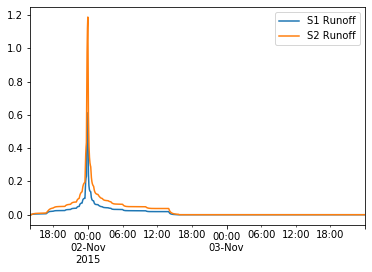

,S1 Runoff,S2 Runoff
count,3480.000000,3480.000000
mean,0.016740,0.033448
std,0.045462,0.088315
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.024201,0.048402
max,0.612882,1.188562


In [12]:
# show the *.out results
df2 = pd.DataFrame({'S1 Runoff': s1_values, 'S2 Runoff': s2_values}, index=timestep)
df2.plot()
plt.show()
df2.describe()

C:\Users\Mel.Meng\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


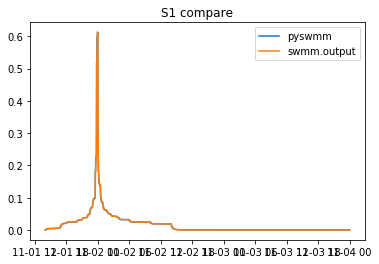

In [13]:
# compare the report results and actual timestep results
plt.plot(df.index, df['S1 Runoff'], label='pyswmm')
plt.plot(df2.index, df2['S1 Runoff'], label='swmm.output')
plt.legend()
plt.title('S1 compare')
plt.show()

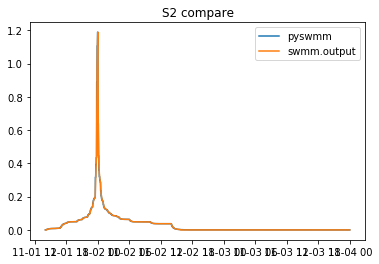

In [14]:
plt.plot(df.index, df['S2 Runoff'], label='pyswmm')
plt.plot(df2.index, df2['S2 Runoff'], label='swmm.output')
plt.legend()
plt.title('S2 compare')
plt.show()

# What's next

Now I learned the basics of running a swmm model and reading the results. Next I would like to try a few more things,

- sensitivity analysis: I need to change my input parameters and see the changes on modeling results.